In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

color_pal = sns.color_palette()

In [42]:
#read X data
df_X = pd.read_csv('data/Germany/input_data.csv')
df_X = df_X.set_index('time')
df_X.index = pd.to_datetime(df_X.index)
df_X = df_X[(df_X.index>='2002-05-01' )& (df_X.index<='2016-12-31')]

#drop three highly correlated columns
#df_X = df_X.drop(columns=['tn','tx','et'])

print(df_X.shape)
df_X.tail()

(5359, 9)


,rr,tg,tn,tx,pp,hu,fg,qq,et
time,,,,,,,,,
2016-12-27,0.0,2.47,1.15,3.53,1039.9000,84.810000,4.71,27.0,0.260880
2016-12-28,0.0,3.51,0.50,4.26,1043.1000,85.750000,3.62,28.0,0.280443
2016-12-29,0.0,-1.31,-4.30,4.44,1042.1000,95.075005,2.09,51.0,0.424098
2016-12-30,0.0,-4.55,-8.41,0.89,1040.6000,94.700005,1.57,50.0,0.360732
2016-12-31,0.0,-4.38,-4.84,-3.52,1037.2001,94.533340,1.41,42.0,0.306081


In [43]:
#read y data
df_y = pd.read_csv('data/Germany/heads.csv')
df_y = df_y.set_index('Date')
df_y.index = pd.to_datetime(df_y.index)
df_y.index = df_y.index.rename("time")
print(df_y.shape)
df_y.tail()

(5359, 1)


,head
time,
2016-12-27,374.55
2016-12-28,374.55
2016-12-29,374.55
2016-12-30,374.55
2016-12-31,374.54


In [44]:
for i in df_X.columns:
    std = np.std(df_X[i],ddof=1)
    mean = np.mean(df_X[i])
    index = (df_X[(df_X[i]>3*std+mean) | (df_X[i]<mean-3*std)]).index
    df_X.drop(index=index,inplace=True)
    df_y.drop(index=index,inplace=True)

print(df_X.shape)
print(df_y.shape)

(5087, 9)
(5087, 1)


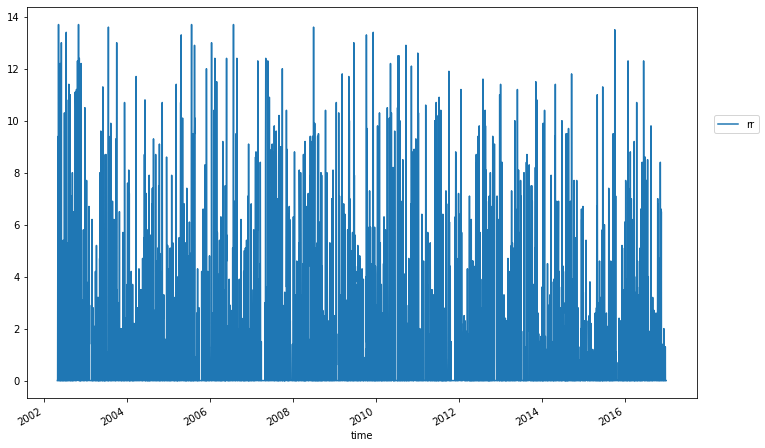

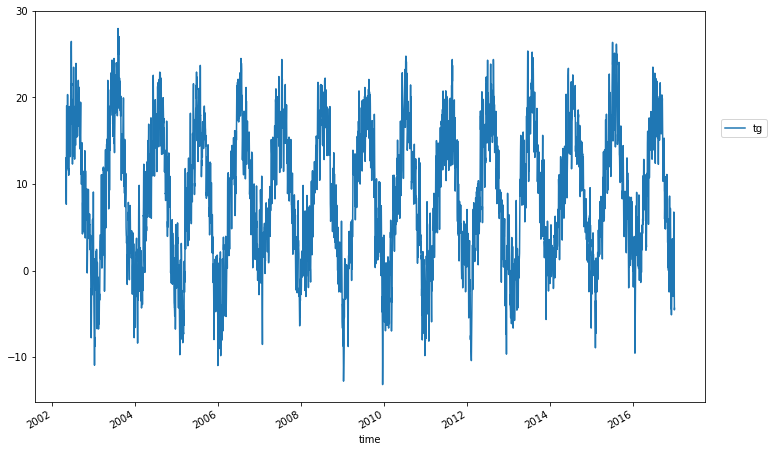

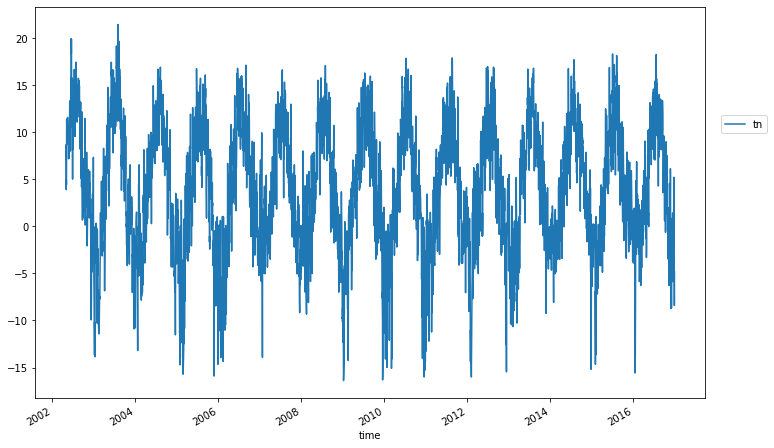

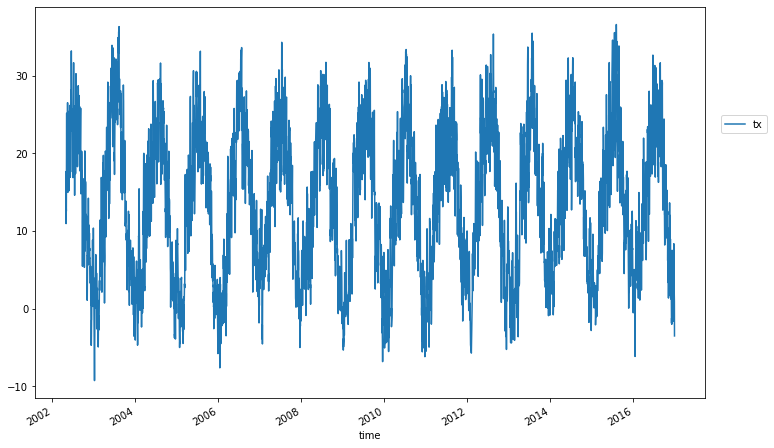

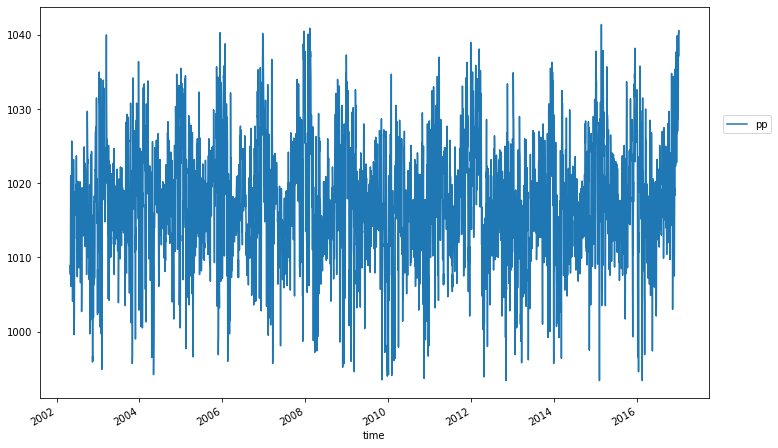

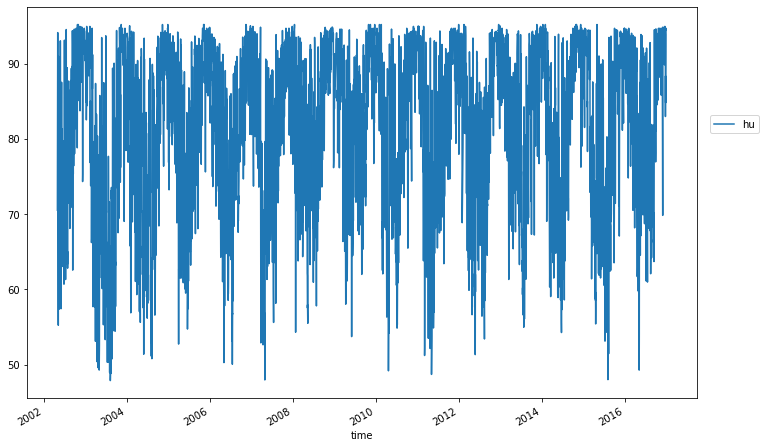

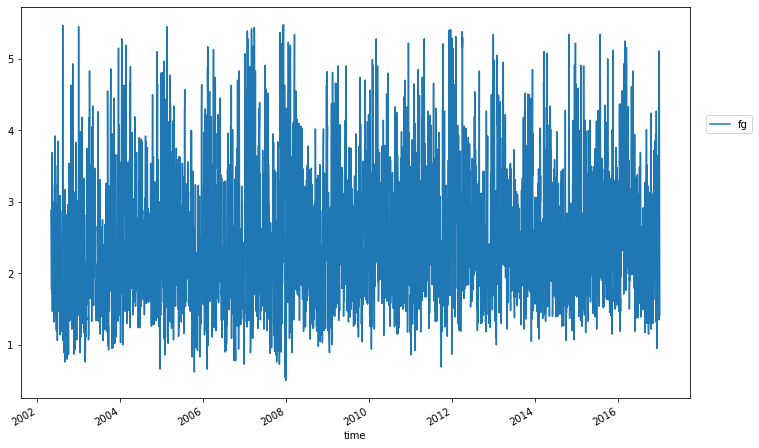

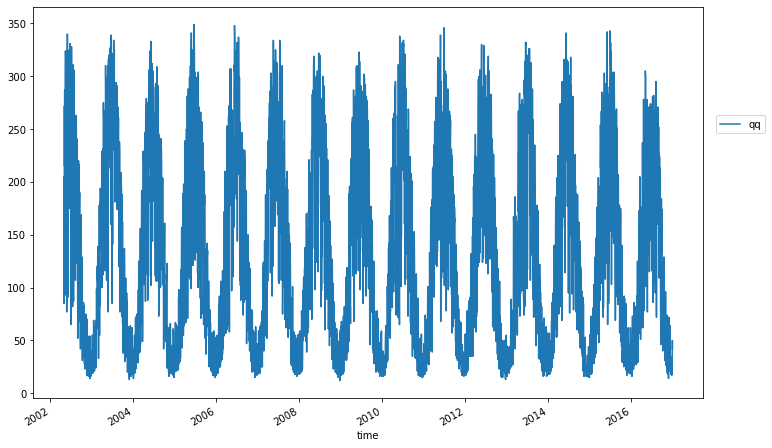

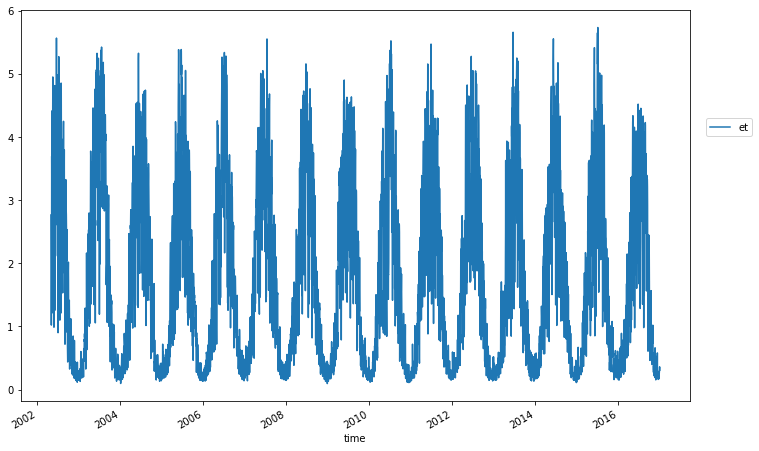

In [45]:
for i in df_X.columns:
    df_X[i].plot(figsize=(12,8))
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.7))
    plt.show()

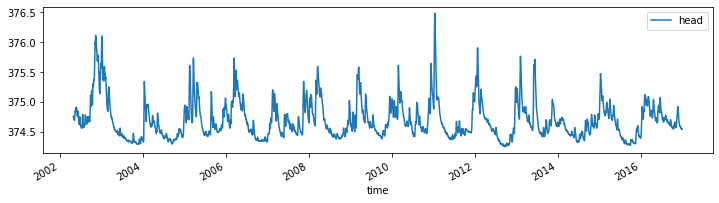

In [46]:
df_y.plot(figsize=(12,3))
plt.show()

In [47]:
def create_features(df):
    df['year'] = df.index.year
    #df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.day_of_week
    #df['quarter'] = df.index.quarter
    return(df)

Index(['rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'et'], dtype='object')
Index(['rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'et', 'year', 'day',
       'dayofweek'],
      dtype='object')


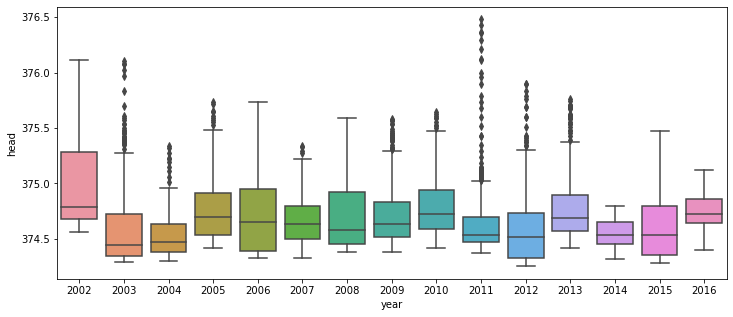

In [48]:
print(df_X.columns)
df_X = create_features(df_X)
print(df_X.columns)

fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x=df_X['year'],y=df_y['head'])
plt.show()

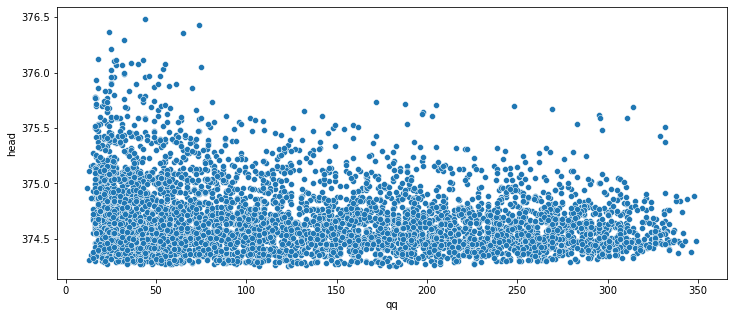

In [49]:
fig, ax = plt.subplots(figsize=(12,5))
sns.scatterplot(x=df_X['qq'],y=df_y['head'],palette='Blues')
plt.show()

# Train / val split

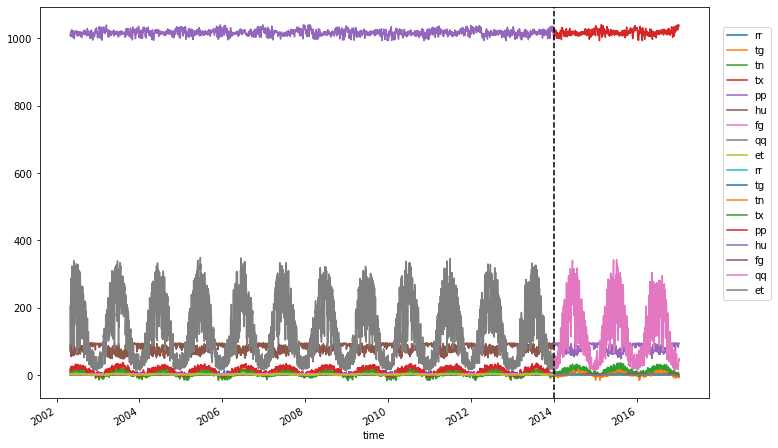

In [50]:
df_X_train = df_X[df_X.index<'2014-01-01']
df_y_train = df_y[df_y.index<'2014-01-01']
df_X_val = df_X[df_X.index>='2014-01-01']
df_y_val = df_y[df_y.index>='2014-01-01']

features = ['rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'et']
#features = ['rr', 'tg', 'pp', 'hu', 'fg', 'qq']

fig, ax = plt.subplots(figsize=(12,8))
df_X_train[features].plot(ax=ax,label="training set")
df_X_val[features].plot(ax=ax,label="test set")
ax.axvline('2014-01-01',color="black",ls="--")
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.6))
plt.show()

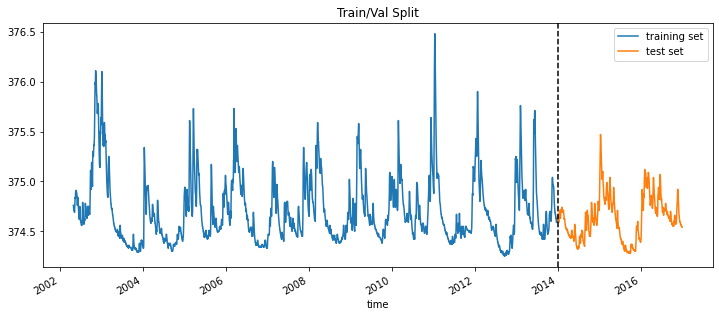

In [51]:
fig, ax = plt.subplots(figsize=(12,5))
df_y_train.plot(ax=ax,label="training set",title="Train/Val Split")
df_y_val.plot(ax=ax,label="test set")
ax.axvline('2014-01-01',color="black",ls="--")
ax.legend(["training set","test set"])
plt.show()

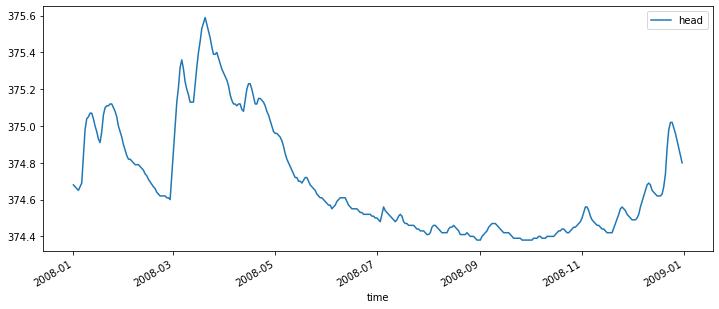

(4039, 12)
(4039, 1)


In [52]:
#see plot in one year
df_y_train[(df_y_train.index>="2008-01-01") & (df_y_train.index<="2008-12-31")].plot(figsize=(12,5))
plt.show()
print(df_X_train.shape)
print(df_y_train.shape)

# Modeling

In [63]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01)
reg.fit(df_X_train,df_y_train,eval_set=[(df_X_train,df_y_train),(df_X_val,df_y_val)],verbose=100)

[0]	validation_0-rmse:370.46445	validation_1-rmse:370.39115
[100]	validation_0-rmse:135.63618	validation_1-rmse:135.56274
[200]	validation_0-rmse:49.66056	validation_1-rmse:49.58672
[300]	validation_0-rmse:18.18454	validation_1-rmse:18.10960
[400]	validation_0-rmse:6.66492	validation_1-rmse:6.58745
[500]	validation_0-rmse:2.45622	validation_1-rmse:2.38068
[600]	validation_0-rmse:0.93313	validation_1-rmse:0.83718
[700]	validation_0-rmse:0.40613	validation_1-rmse:0.31241
[800]	validation_0-rmse:0.25013	validation_1-rmse:0.19561
[883]	validation_0-rmse:0.21470	validation_1-rmse:0.19436


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

# Feature Importance

In [64]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=["importance"])

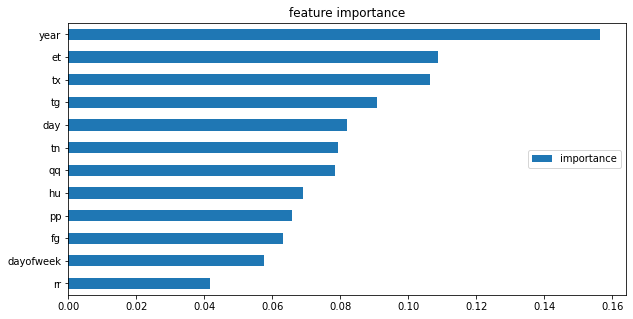

In [65]:
fi.sort_values('importance').plot(kind='barh',title="feature importance",figsize=(10,5))
plt.legend(loc='right')
plt.show()

# prediction on val

In [66]:
prediction = pd.DataFrame(reg.predict(df_X_val),index=df_y_val.index)

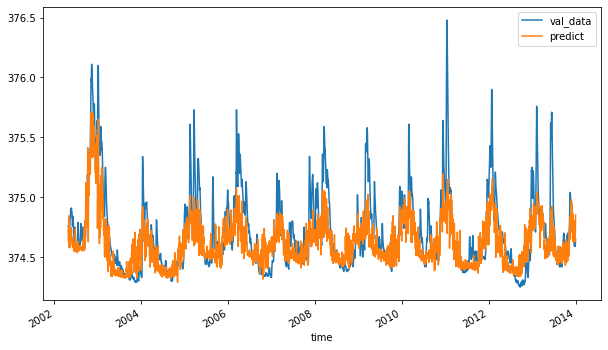

0.05318958903594867

In [67]:
#performance in train data
ax = df_y_train.plot(figsize=(10,6))
pd.DataFrame(reg.predict(df_X_train),index=df_y_train.index).plot(ax=ax)
plt.legend(["val_data","predict"])
plt.show()
mean_squared_error(df_y_train,pd.DataFrame(reg.predict(df_X_train),index=df_y_train.index))

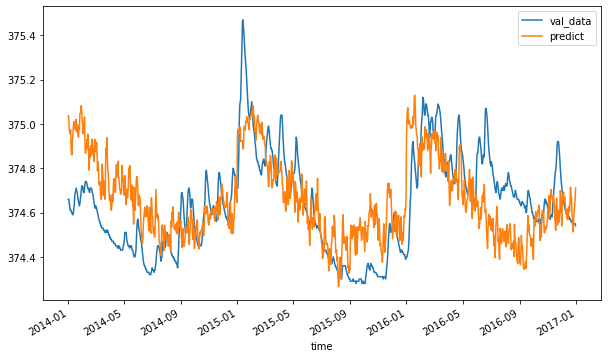

In [39]:
#performance in validation data
ax = df_y_val.plot(figsize=(10,6))
prediction.plot(ax=ax)
plt.legend(["val_data","predict"])
plt.show()

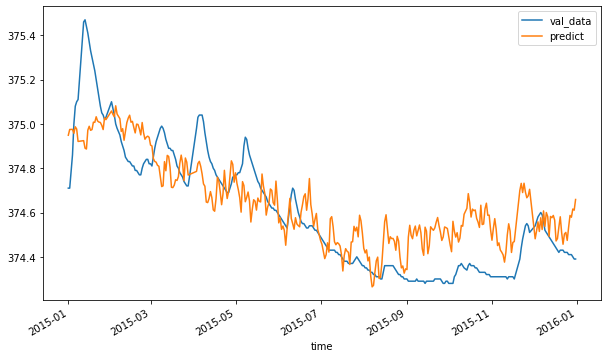

In [36]:
ax = df_y_val[(df_y_val.index>="2015-01-01") & (df_y_val.index<="2015-12-31")].plot(figsize=(10,6))
prediction[(prediction.index>="2015-01-01") & (prediction.index<="2015-12-31")].plot(ax=ax)
plt.legend(["val_data","predict"])
plt.show()


In [37]:
np.sqrt(mean_squared_error(df_y_val,prediction))

0.19121721296803604

In [38]:
mean_squared_error(df_y_val,prediction)

0.036564022535263245

# Lasso

In [31]:
from sklearn.linear_model import Lasso
reg = Lasso(alpha=0.001)
reg.fit(df_X_train,df_y_train.values.ravel())
y_predict = reg.predict(df_X_val)

print(y_predict)

[375.03644357 375.02757257 374.97777869 ... 374.58011857 374.65905256
 374.7108409 ]


In [32]:
mean_squared_error(df_y_val,y_predict)

0.036564022535263245

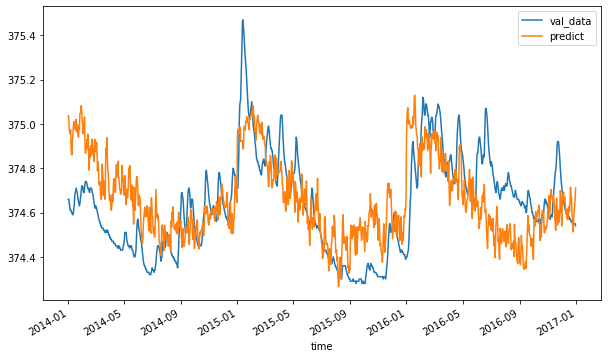

In [33]:
prediction = pd.DataFrame(y_predict,index=df_y_val.index)
ax = df_y_val.plot(figsize=(10,6))
prediction.plot(ax=ax)
plt.legend(["val_data","predict"])
plt.show()

# random forest

In [638]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=100,max_depth=6)
reg.fit(df_X_train,df_y_train.values.ravel())
y_predict = reg.predict(df_X_val)

print(y_predict)

[374.89457299 374.89947054 374.81873906 ... 374.9323476  374.98739074
 375.01579429]


In [639]:
mean_squared_error(df_y_val,y_predict)

0.05031088355873548

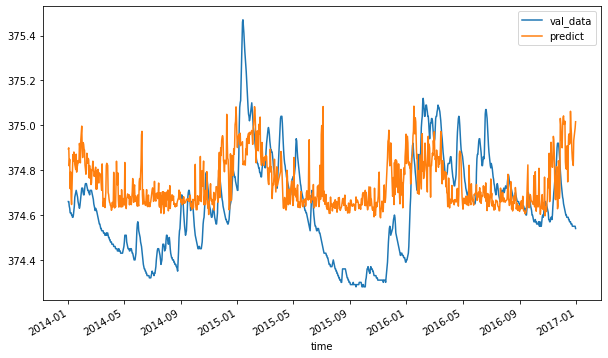

In [640]:
prediction = pd.DataFrame(y_predict,index=df_y_val.index)
ax = df_y_val.plot(figsize=(10,6))
prediction.plot(ax=ax)
plt.legend(["val_data","predict"])
plt.show()

# SVR

In [21]:
from sklearn.svm import SVR
reg = SVR(C =15)
reg.fit(df_X_train,df_y_train.values.ravel())
y_predict = reg.predict(df_X_val)

In [27]:
mean_squared_error(df_y_val,y_predict)

0.03651783280001982

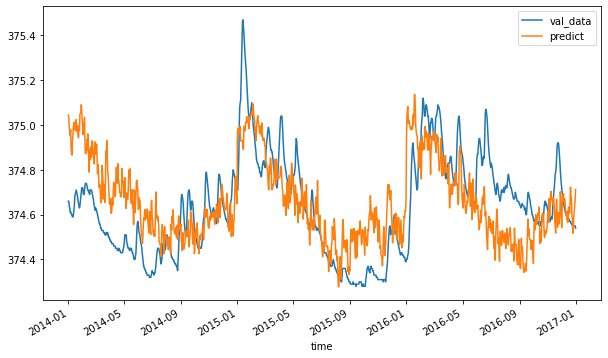

In [28]:
prediction = pd.DataFrame(y_predict,index=df_y_val.index)
ax = df_y_val.plot(figsize=(10,6))
prediction.plot(ax=ax)
plt.legend(["val_data","predict"])
plt.show()

# lin

In [29]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(df_X_train,df_y_train)
y_predict = reg.predict(df_X_val)
mean_squared_error(df_y_val,y_predict)

0.03651783280001982

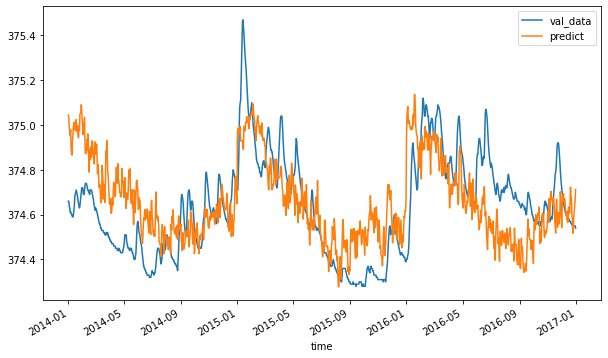

In [30]:
prediction = pd.DataFrame(y_predict,index=df_y_val.index)
ax = df_y_val.plot(figsize=(10,6))
prediction.plot(ax=ax)
plt.legend(["val_data","predict"])
plt.show()

# pipline

In [106]:
# read in the data and add your function in this cell
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


# df_X_train = df_X[df_X.index<'2014-01-01']
# df_y_train = df_y[df_y.index<'2014-01-01']
# df_X_val = df_X[df_X.index>='2014-01-01']
# df_y_val = df_y[df_y.index>='2014-01-01']

# The function which takes the unprocessed feature matrix, target variable, 
# a preprocessor (ColumnTransformer), an initialized ML algorithm, and a correspondig parameter grid as inputs.
def MLpipe_KFold_RMSE(ColumnTransformer, ML_algorithm, parameter_grid):
    
    # collect all the encoders into one preprocessor
    preprocessor = ColumnTransformer

    prep = Pipeline(steps=[('preprocessor', preprocessor)]) 
    
    # Use GridSearchCV and the parameter names need to contain the ML algorithm
    param_grid = parameter_grid 
    
    nr_states = 1 # number of random states
    test_scores = np.zeros(nr_states)
    final_models = []

    for i in range(nr_states):
        # first split to separate out the test set
        # use kfold on other
        feature_matrix_other=df_X[df_X.index<'2014-01-01']
        feature_matrix_test=df_X[df_X.index>='2014-01-01']
        target_variable_other=df_y[df_y.index<'2014-01-01']
        target_variable_test=df_y[df_y.index>='2014-01-01']
        target_variable_other=target_variable_other.values.ravel()
        target_variable_test=target_variable_test.values.ravel()


        # splitter for other using k kfold
        kf = KFold(n_splits=4,shuffle=True,random_state=42*i)

        # the classifier
        if ML_algorithm in [SVR, KNeighborsRegressor]:
            clf = ML_algorithm()
        else:
            clf = ML_algorithm(random_state = 42*i) # initialize the classifier
        
        
        # put together a pipeline
        # the pipeline will fit_transform the training set (4 folds), and transform the last fold used as validation
        # then it will train the ML algorithm on the training set and evaluate it on the validation set
        # it repeats this step automatically such that each fold will be an evaluation set once
        pipe = make_pipeline(preprocessor,clf)

        # use GridSearchCV
        # GridSearchCV loops through all parameter combinations and collects the results 
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'neg_mean_squared_error',
                            cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
        
        # this line actually fits the model on other
        grid.fit(feature_matrix_other, target_variable_other)
        # save results into a data frame.
        results = pd.DataFrame(grid.cv_results_)
        #print(results)

        print('best model parameters:',grid.best_params_)
        #print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        final_models.append(grid)
        # calculate and save the test score
        target_variable_test_pred = final_models[-1].predict(feature_matrix_test)
        test_scores[i] = (mean_squared_error(target_variable_test,target_variable_test_pred)) #use RMSE as test score
        print('test score:',test_scores[i])
    
    # print out mean and std of test scores
    print('mean of test scores:',np.mean(test_scores))
    #print('standard deviation of test scores:',np.std(test_scores,ddof=1))

In [107]:
# run l1 regularized linear regression to test your function in this cell

onehot_ftrs = ['year','day','dayofweek']
std_ftrs = ['rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'et']
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),('std', StandardScaler(), std_ftrs)])
ML_algorithm=Lasso
parameter_grid = {'lasso__alpha': np.logspace(-2,2,11)} 

MLpipe_KFold_RMSE(columnTransformer, ML_algorithm, parameter_grid)

Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.042075846755097686
mean of test scores: 0.042075846755097686


In [108]:
onehot_ftrs = ['year','day','dayofweek']
std_ftrs = ['rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'et']
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),('std', StandardScaler(), std_ftrs)])
ML_algorithm=SVR
parameter_grid = {'svr__gamma': [1e-2, 1e-1, 1e1, 1e2, 1e3],'svr__C': [1e-1, 1e0, 1e1]} 

MLpipe_KFold_RMSE(columnTransformer, ML_algorithm, parameter_grid)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 1.0, 'svr__gamma': 0.1}
test score: 0.04606812587896326
mean of test scores: 0.04606812587896326


In [ ]:
onehot_ftrs = ['year','day','dayofweek']
std_ftrs = ['rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'et']
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),('std', StandardScaler(), std_ftrs)])
ML_algorithm=SVR
parameter_grid = {'svr__gamma': [1e-2, 1e-1, 1e1, 1e2, 1e3],'svr__C': [1e-1, 1e0, 1e1]} 

MLpipe_KFold_RMSE(columnTransformer, ML_algorithm, parameter_grid)